In [16]:
import regex
import pandas as pd
import numpy as np
import emoji
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [17]:
def date_time(s):
    pattern = '^([0-9]+)(\/)([0-9]+)(\/)([0-9]+), ([0-9]+):([0-9]+)[ ]?(AM|PM|am|pm)? -'
    result = regex.match(pattern, s)
    if result:
        return True
    return False

def find_author(s):
    s = s.split(":")
    if len(s)==2:
        return True
    else:
        return False

def getDatapoint(line):
    splitline = line.split(' - ')
    dateTime = splitline[0]
    date, time = dateTime.split(", ")
    message = " ".join(splitline[1:])
    if find_author(message):
        splitmessage = message.split(": ")
        author = splitmessage[0]
        message = " ".join(splitmessage[1:])
    else:
        author= None
    return date, time, author, message

In [18]:
data = []
conversation = 'WhatsApp Chat with Central.txt'
with open(conversation, encoding="utf-8") as fp:
    fp.readline()
    messageBuffer = []
    date, time, author = None, None, None
    while True:
        line = fp.readline()
        if not line:
            break
        line = line.strip()
        if date_time(line):
            if len(messageBuffer) > 0:
                data.append([date, time, author, ' '.join(messageBuffer)])
            messageBuffer.clear()
            date, time, author, message = getDatapoint(line)
            messageBuffer.append(message)
        else:
            messageBuffer.append(line)

In [19]:
df = pd.DataFrame(data, columns=["Date", 'Time', 'Author', 'Message'])
df['Date'] = pd.to_datetime(df['Date'])
print(df.tail(20))
print(df.info())
print(df.Author.unique())

         Date   Time                  Author  \
56 2022-02-16  12:55         +91 89255 33488   
57 2022-02-16  12:55         +91 89255 33488   
58 2022-02-16  12:55         +91 89255 33488   
59 2022-02-16  13:11      Senthilsir_pantech   
60 2022-02-16  13:30         +91 89255 33488   
61 2022-02-16  14:12         +91 89255 33488   
62 2022-02-16  14:12         +91 89255 33488   
63 2022-02-16  14:13         +91 80983 22090   
64 2022-02-16  14:13         +91 89255 33488   
65 2022-02-16  15:15  Kumaraswamysir_pantech   
66 2022-02-16  15:30          Malaiappan Sir   
67 2022-02-16  16:25         +91 89255 33488   
68 2022-02-16  16:25         +91 89255 33488   
69 2022-02-16  16:26                Nandhini   
70 2022-02-16  16:52      Senthilsir_pantech   
71 2022-02-17  16:01                    None   
72 2022-02-17  17:27         +91 89255 33488   
73 2022-02-18  09:34      Senthilsir_pantech   
74 2022-02-19  10:56  Kumaraswamysir_pantech   
75 2022-02-19  10:56  Kumaraswamysir_pan

In [20]:
# Total number of messages:
total_messages = df.shape[0]
print(total_messages)

76


In [21]:
# Total number of media messages:
media_messages = df[df["Message"]=='<Media omitted>'].shape[0]
print(media_messages)

0


In [22]:
def split_count(text):
    emoji_list = []
    data = regex.findall(r'\X',text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)
    return emoji_list
df['emoji'] = df["Message"].apply(split_count)

emojis = sum(df['emoji'].str.len())
print(emojis)

0


In [23]:
URLPATTERN = r'(https?://\S+)'
df['urlcount'] = df.Message.apply(lambda x: regex.findall(URLPATTERN, x)).str.len()
links = np.sum(df.urlcount)

print("Chats between Senthilsir_pantech and Kumaraswamysir_pantech")
print("Total Messages: ", total_messages)
print("Number of Media Shared: ", media_messages)
print("Number of Emojis Shared", emojis)
print("Number of Links Shared", links)

Chats between Senthilsir_pantech and Kumaraswamysir_pantech
Total Messages:  76
Number of Media Shared:  0
Number of Emojis Shared 0
Number of Links Shared 1


In [24]:
media_messages_df = df[df['Message'] == '<Media omitted>']
messages_df = df.drop(media_messages_df.index)
messages_df['Letter_Count'] = messages_df['Message'].apply(lambda s : len(s))
messages_df['Word_Count'] = messages_df['Message'].apply(lambda s : len(s.split(' ')))
messages_df["MessageCount"]=1

l = ["Senthilsir_pantech", "Kumaraswamysir_pantech"]
for i in range(len(l)):
  # Filtering out messages of particular user
  req_df= messages_df[messages_df["Author"] == l[i]]
  # req_df will contain messages of only one particular user
  print(f'Stats of {l[i]} -')
  # shape will print number of rows which indirectly means the number of messages
  print('Messages Sent', req_df.shape[0])
  #Word_Count contains of total words in one message. Sum of all words/ Total Messages will yield words per message
  words_per_message = (np.sum(req_df['Word_Count']))/req_df.shape[0]
  print('Average Words per message', words_per_message)
  #media conists of media messages
  media = media_messages_df[media_messages_df['Author'] == l[i]].shape[0]
  print('Media Messages Sent', media)
  # emojis conists of total emojis
  emojis = sum(req_df['emoji'].str.len())
  print('Emojis Sent', emojis)
  #links consist of total links
  links = sum(req_df["urlcount"])   
  print('Links Sent', links)

Stats of Senthilsir_pantech -
Messages Sent 8
Average Words per message 6.125
Media Messages Sent 0
Emojis Sent 0
Links Sent 0
Stats of Kumaraswamysir_pantech -
Messages Sent 20
Average Words per message 8.55
Media Messages Sent 0
Emojis Sent 0
Links Sent 0


There are 3570 words in all the messages.


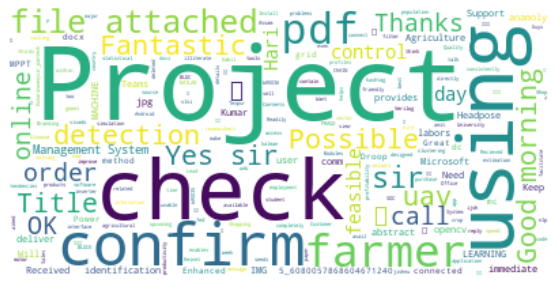

In [26]:
text = " ".join(review for review in messages_df.Message)
print ("There are {} words in all the messages.".format(len(text)))
stopwords = set(STOPWORDS)
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
# Display the generated image:
# the matplotlib way:
plt.figure( figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Author name Senthilsir_pantech


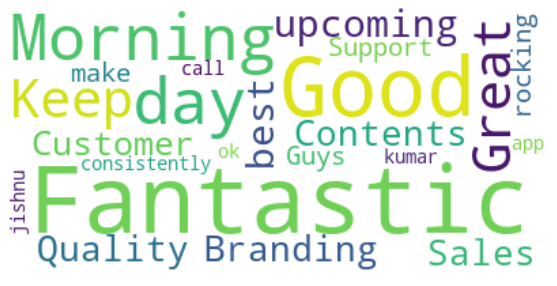

Author name Kumaraswamysir_pantech


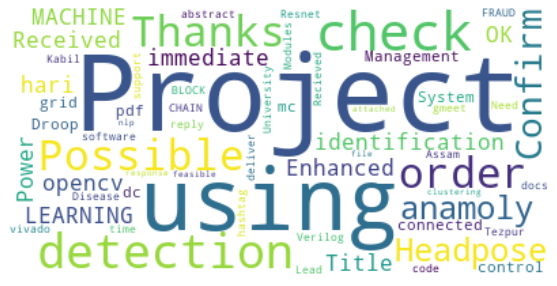

In [27]:
l = ["Senthilsir_pantech", "Kumaraswamysir_pantech"]
for i in range(len(l)):
  dummy_df = messages_df[messages_df['Author'] == l[i]]
  text = " ".join(review for review in dummy_df.Message)
  stopwords = set(STOPWORDS)
  #Generate a word cloud image
  print('Author name',l[i])
  wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
  #Display the generated image   
  plt.figure( figsize=(10,5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

In [28]:
df

,Date,Time,Author,Message,emoji,urlcount
0,NaT,None,None,ijsh.2014.8.6.13.pdf,[],0
1,2022-09-02,23:31,+91 80983 22090,Want to talk with student sir,[],0
2,2022-09-02,23:31,+91 80983 22090,Same,[],0
3,2022-10-02,13:11,+91 89255 33488,+919010349904,[],0
4,2022-10-02,19:50,+91 88971 34578,தயவு செய்து உபயோகிக்கவும் Microsoft Teams. அ...,[],0
...,...,...,...,...,...,...
71,2022-02-17,16:01,None,+91 88971 34578: https://youtu.be/poc3HqBuw-8,[],1
72,2022-02-17,17:27,+91 89255 33488,Super..,[],0
73,2022-02-18,09:34,Senthilsir_pantech,Good Morning All... Have a great day....💡💡,[],0
74,2022-02-19,10:56,Kumaraswamysir_pantech,Enhanced Power Management System for Droop con...,[],0


In [10]:
import pandas as pd
from nltk.corpus import stopwords
messages = []
data = []
stop_words = set(stopwords.words('english'))
df = pd.DataFrame(data, columns=["Date", 'Time', 'Author', 'Message'])
for words in df['Message']:
    only_letters = re.sub("[^a-zA-Z]", " ",words)
    tokens = nltk.word_tokenize(only_letters) #tokenize the sentences
    lower_case = [l.lower() for l in tokens] #convert all letters to lower case
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case)) #Remove stopwords from the comments
    lemmas = [wordnet_lemmatizer.lemmatize(t) for t in filtered_result] #lemmatizes the words i.e convert similar words to their
    # base form while still considering the context in which the words are used 
    
    messages.append(' '.join(lemmas))  

In [21]:
# Function to detect the date at the start of the line to make each row unique.
def DateTime(s):
    regex_format = '^([0-9]+)(\/)([0-9]+)(\/)([0-9]+), ([0-9]+):([0-9]+)[ ]?(AM|PM|am|pm)? -' 
    result = re.match(regex_format, s)
    if result:
        return True
    return False

# Function to extract the group chat participant names
def Participants(a):
  a=a.split(":")
  if len(a)==2:
    return True
  else:
    return False

# Function to organize the data properly to be represented as a pandas dataframe
def GetDataPoints(line):   
    splitLine = line.split(' - ') 
    dateTime = splitLine[0]
    date, time = dateTime.split(', ') 
    message = ' '.join(splitLine[1:])
    if Participants(message): 
        splitMessage = message.split(': ') 
        participants = splitMessage[0] 
        message = ' '.join(splitMessage[1:])
    else:
        participants = None
    return date, time, participants, message

 # Function to extract the emojis and add them to a new column
def split_count(text):

    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)

    return emoji_list

In [23]:
import regex 
import re, nltk
parsedData=[]
data = [] 
text_data = 'WhatsApp Chat with Central.txt' # replace with the file name of your text data
with open(text_data, encoding="utf-8") as fp: #fp stands for file pointer and helps in reading in the data
    fp.readline()
    messageBuffer = [] 
    date, time, participants = None, None, None
    while True:
        line = fp.readline() 
        if not line: 
            break
        line = line.strip() 
        if DateTime(line): 
            if len(messageBuffer)> 0: 
                parsedData.append([date, time, participants, ' '.join(messageBuffer)]) 
            messageBuffer.clear() 
            date, time, participants, message = GetDataPoints(line) 
            messageBuffer.append(message) 
        else:
            messageBuffer.append(line)

In [25]:
import emoji
clean_data = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Participants', 'Message']) # Reading in the data in a dataframe form
clean_data["Date"] = pd.to_datetime(clean_data["Date"])# making sure the date column is in a datetime format.  
clean_data["emoji"] = clean_data["Message"].apply(split_count) # Applying the emoji function to extract the emojis from the messages.

clean_data.head(10) # Having a look at the first 10 entries

,Date,Time,Participants,Message,emoji
0,NaT,None,None,ijsh.2014.8.6.13.pdf,[]
1,2022-09-02,23:31,+91 80983 22090,Want to talk with student sir,[]
2,2022-09-02,23:31,+91 80983 22090,Same,[]
3,2022-10-02,13:11,+91 89255 33488,+919010349904,[]
4,2022-10-02,19:50,+91 88971 34578,தயவு செய்து உபயோகிக்கவும் Microsoft Teams. அ...,[]
5,2022-10-02,19:52,+91 88971 34578,Install Microsoft Teams in Office Systems,[]
6,2022-12-02,16:42,+91 89255 33488,SOC estimation using kalman filter,[]
7,2022-12-02,16:42,+91 89255 33488,Check and confirm @918098322090,[]
8,2022-12-02,17:46,+91 80983 22090,This vlsi sir,[]
9,2022-12-02,17:47,Kumaraswamysir_pantech,Can you check with Kabil & Confirm it ?,[]


In [26]:
clean_data = clean_data[clean_data.Message != '<Media omitted>']
clean_data = clean_data[clean_data.Message != 'This message was deleted']
clean_data = clean_data[clean_data.Message != 'You were added'] 

In [29]:
from nltk.stem import WordNetLemmatizer 
wordnet_lemmatizer = WordNetLemmatizer()
messages = []
stop_words = set(stopwords.words('english'))

for words in clean_data['Message']:
    only_letters = re.sub("[^a-zA-Z]", " ",words)
    tokens = nltk.word_tokenize(only_letters) #tokenize the sentences
    lower_case = [l.lower() for l in tokens] #convert all letters to lower case
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case)) #Remove stopwords from the comments
    lemmas = [wordnet_lemmatizer.lemmatize(t) for t in filtered_result] #lemmatizes the words i.e convert similar words to their
    # base form while still considering the context in which the words are used 
    
    messages.append(' '.join(lemmas))    

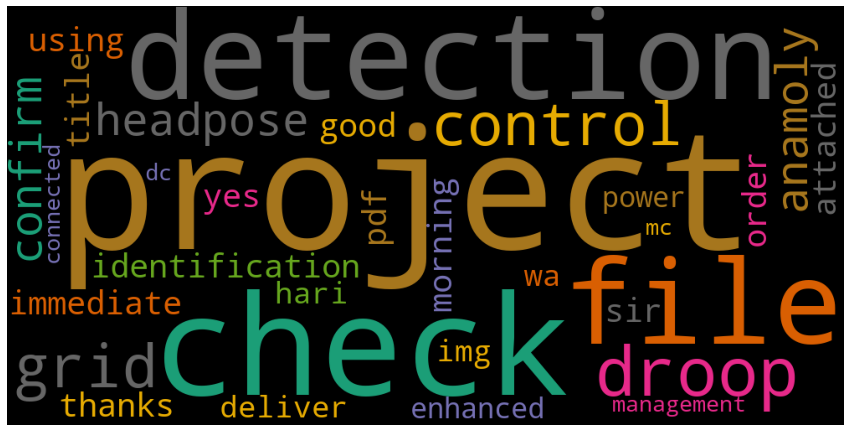

In [32]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
#let us find the most important words in messages using countvectorizer
cv = CountVectorizer(analyzer = "word",stop_words = 'english',max_features = 20,ngram_range=(2,2))
important_words = cv.fit_transform(messages)
fig_words = cv.vocabulary_

#wordcloud for important words 
unique_data=(" ").join(fig_words)
wordcloud = WordCloud(width = 1000, height = 500,colormap="Dark2").generate(unique_data)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
plt.close()

In [33]:
co = CountVectorizer(ngram_range=(2,2),stop_words='english')
counts = co.fit_transform(messages)
pd.DataFrame(counts.sum(axis=0),columns=co.get_feature_names()).T.sort_values(0,ascending=False).head(50)

,0
file attached,6
yes sir,4
good morning,4
check confirm,4
project title,3
project order,3
check hari,3
pdf file,3
enhanced power,2
uav uav,2


In [50]:
# We only need the Headlines text column from the data
data_text = df[['Message']];

In [56]:
import sys
import pickle
data_text = data_text.astype('str');
for idx in range(len(data_text)):
    
    #go through each word in each data_text row, remove stopwords, and set them on the index.
    data_text.iloc[idx]['Message'] = [word for word in data_text.iloc[idx]['Message'].split(' ')];
    
    #print logs to monitor output
    if idx % 1000 == 0:
        sys.stdout.write('\rc = ' + str(idx) + ' / ' + str(len(data_text)));
#save data because it takes very long to remove stop words
pickle.dump(data_text, open('data_text.dat', 'wb'))
#get the words as an array for lda input
train_headlines = [value[0] for value in data_text.iloc[0:].values];

c = 0 / 76

In [57]:
# Implementing LDA:
num_topics = 5;

In [67]:
import gensim
from gensim import corpora
from gensim import models
from gensim.models import LdaModel
id2word = gensim.corpora.Dictionary(train_headlines);
corpus = [id2word.doc2bow(text) for text in train_headlines];
lda = LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics);

In [68]:
# Generating LDA Topics:
def get_lda_topics(model, num_topics):
    word_dict = {};
    for i in range(num_topics):
        words = model.show_topic(i, topn = 20);
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words];
    return pd.DataFrame(word_dict);

In [69]:
get_lda_topics(lda, num_topics)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05
0,"'for',","['Good',","'are',","'to',","'',"
1,'?'],"'a',","'using',","'(file',","'and',"
2,"'this',","'',","['This',","'attached)',","'check',"
3,"'sir',","'morning',","'and',","'the',","'Project',"
4,"['Yes',","'fantastic',","'the',","'a',","'👍👍',"
5,"',',","'on',","'project',","'uav',","'you',"
6,"'the',","'Morning',","['Yes',",'sir'],'?']
7,"'can',","'all...Have',","'sir',","'in',","'for',"
8,"'using',","'to',","'with',","'control',","'can',"
9,"['@919566307833',","'the',","'method',","'System',","'to',"


In [70]:
# Implementing NMF:
#the count vectorizer module needs string inputs, not array, so I join them with a space. This is a very quick operation.
train_headlines_sentences = [' '.join(text) for text in train_headlines]

In [73]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer;
vectorizer = CountVectorizer(analyzer='word', max_features=5000);
x_counts = vectorizer.fit_transform(train_headlines_sentences);

In [74]:
transformer = TfidfTransformer(smooth_idf=False);
x_tfidf = transformer.fit_transform(x_counts);

In [79]:
from sklearn import preprocessing
xtfidf_norm = preprocessing.normalize(x_tfidf, norm='l1', axis=1)


In [81]:
from sklearn.decomposition import NMF;
#obtain a NMF model.
model = NMF(n_components=num_topics, init='nndsvd');
#fit the model
model.fit(xtfidf_norm)

NMF(init='nndsvd', n_components=5)

In [82]:
def get_nmf_topics(model, n_top_words):
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = vectorizer.get_feature_names()
    
    word_dict = {};
    for i in range(num_topics):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:-20 - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words;
    
    return pd.DataFrame(word_dict);

In [83]:
get_nmf_topics(model, 20)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05
0,sir,ok,possible,919566307833,fantastic
1,yes,kumar,918098322090,check,all
2,feasible,will,yes,confirm,morning
3,vlsi,you,code,and,good
4,this,confirm,software,918098322090,day
5,will,yes,verilog,you,have
6,call,message,vivado,with,keep
7,the,deleted,on,can,guys
8,projects,call,confirm,919840974406,make
9,both,9884210250,and,hari,rocking
